# Outage probability in OFDMA protocol
## Macs 207 B

Students : Vincent Herfeld, Maxime Megel, Simon Queric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats import poisson, uniform, kstest, ksone

In [2]:
# NUMERICAL VALUES
C = 200
W = 250
K = 1e6
gamma = 2.8
R = 300
lamb = 0.01
SNR = 0.1
p = 0.01
Smin = 30
Smax = 100

### Question 1

We consider the function $q$ defined as follow :

$\displaystyle\begin{array}{r | l c l}
 & \mathbb{R}^2 & \longrightarrow & [0,1]\\
 f :& & & \\
 & x & \longmapsto & p
\end{array}$

If $\tilde{\phi}$ is the Poisson process of all users, then the process $\phi$ of all active users is the process $\tilde{\phi}$ thined by the function $f$. We know that this process **is also a Poisson process** and it's intensity measure is defined by :

$\displaystyle \mu_p(A) = \int_Af(x)\lambda\,dx = \lambda p \int_Adx$

Therefore $\boxed{\mathbf{d\mu_p = \lambda p dx}}$

### Question 2

The area of the cell measures $\pi R^2$, hence **the mean number of active users in the cell is** $\mathbf{\lambda p \pi R^2}$ 

### Question 3

Let $k \in \{1, \dots, N_{\max} \}$ and $x$ be the position of a given customer. 

$ \begin{aligned} \displaystyle
    &N(x) = k \\
    \Longleftrightarrow & k-1 < \frac{C}{W\log_2{(1 + K\|x\|^{-\gamma})}} \leqslant k \\
    \Longleftrightarrow & 2^{\frac{C}{Wk}}< 1 + K\|x\|^{-\gamma} \leqslant 2^{\frac{C}{W(k-1)}} \\
    \Longleftrightarrow & \left( \frac{K}{2^{\frac{C}{W(k-1)}} - 1} \right)^{1/\gamma} 
    < \|x\| \leqslant \left( \frac{K}{2^{\frac{C}{Wk}} - 1} \right)^{1/\gamma} 
\end{aligned}$

We've shown that the subset of the cell in which all customers required $k$ subcarriers is **an annulus whose radii are the left and right members of the last inequality.**

### Question 4

The number $A_3$ of customers requiring $3$ subcarriers follows a **Poisson distribution** of parameter $\lambda p \pi \left(\left( \frac{K}{2^{\frac{C}{3W}} - 1} \right)^{2/\gamma} - \left( \frac{K}{2^{\frac{C}{2W}} - 1} \right)^{2/\gamma}\right)$

### Question 5

We first code a simulation of our spatial point process :

In [3]:
def draw():
    N = poisson.rvs(mu=lamb*p*np.pi*R**2)    
    u, v = uniform.rvs(size=N), uniform.rvs(size=N)
    x, y = R*np.sqrt(u)*np.cos(2*np.pi*v), R*np.sqrt(u)*np.sin(2*np.pi*v)  
    return x, y, N

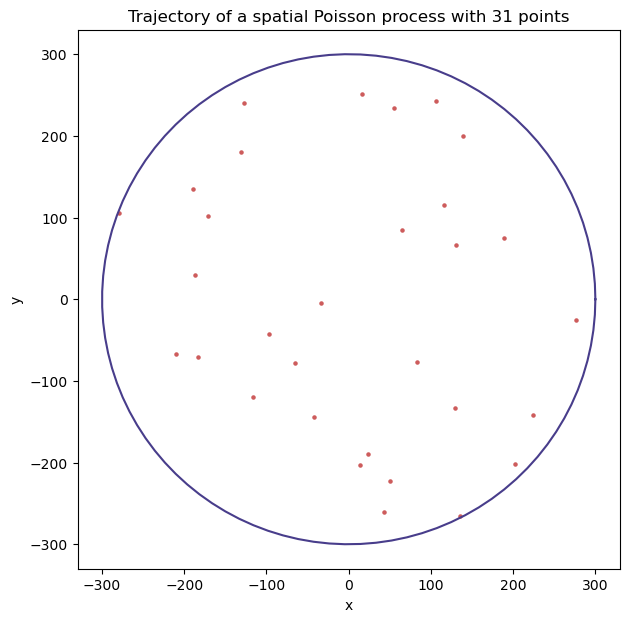

In [4]:
x, y, N = draw()
t = np.linspace(0, 2*np.pi, 100)
fig = plt.figure(figsize=(7, 7))

plt.plot(R*np.cos(t), R*np.sin(t), color='darkslateblue')
plt.scatter(x, y, s = 5, c = 'indianred')

plt.title(f'Trajectory of a spatial Poisson process with {N} points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We now we want to test if the draws indeed follow the desired distribution :

In [5]:
def test(u, v, rmin2, rmax2):
    res = []
    n = len(u)
    for i in range(n):
        norm = u[i]**2 + v[i]**2
        if rmin2 <= norm and norm <= rmax2:
            res.append(True)
        else:
            res.append(False)
    return np.array(res)

In [6]:
def squared_radius(k):
    return (K / (2**(C / (k*W)) - 1))**(2/gamma)

In [7]:
rmin2 = squared_radius(2)
rmax2 = squared_radius(3)
N_draws = 10**4

c = []
for _ in range(N_draws):
    x, y, N = draw()
    c.append(np.count_nonzero(test(x, y, rmin2, rmax2)))
c = np.array(c)

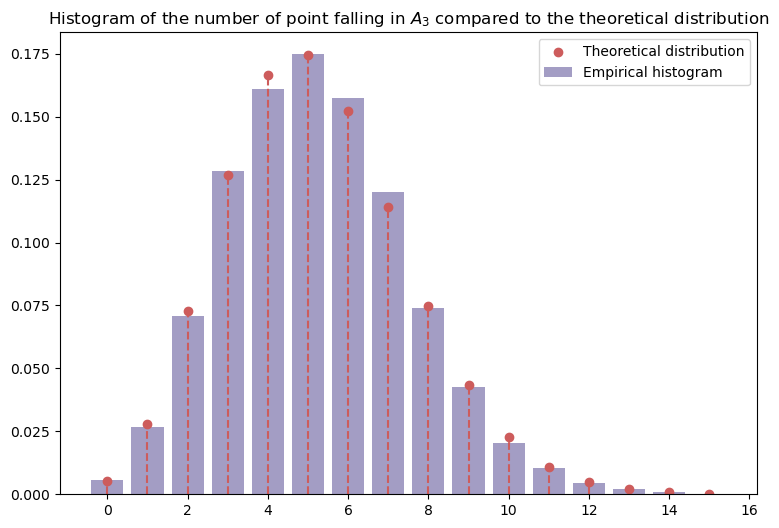

In [8]:
h, b = np.histogram(c, bins = np.arange(c.min(), c.max() + 1), density = True)
b = b[:-1]

lambd = lamb * p * np.pi * (rmax2 - rmin2)
pdf = [np.exp(-lambd) * lambd **k / np.math.factorial(k) for k in b]

plt.figure(figsize = (9,6))

plt.bar(b, h, color = 'darkslateblue', alpha = 0.5, label = 'Empirical histogram')
plt.scatter(b, pdf, c = 'indianred', label = 'Theoretical distribution')
for k in range(len(b)):
    plt.plot([k, k], [0, pdf[k]], ls = '--', c = 'indianred')

plt.title(r'Histogram of the number of point falling in $A_3$ compared to the theoretical distribution')
plt.legend()
plt.show()

The visual results are convincing. We now perform the Kolmogorov-Smirnoff test :

In [9]:
ks = kstest(c, 'poisson', args = [lambd])
ks

KstestResult(statistic=0.1806996329925996, pvalue=3.5092271293785143e-286, statistic_location=5, statistic_sign=-1)

In [10]:
poiss = poisson.rvs(lambd, size = 10000)
cdf = lambda x : poisson.cdf(x,lambd)
ks = kstest(poiss, 'poisson', args = [lambd])
ks

KstestResult(statistic=0.1751996329925996, pvalue=6.22606608673115e-269, statistic_location=5, statistic_sign=-1)

Trop bizarre même en tirant des trucs explicitement de poisson j'ai un résultat dégueu

### Question 6

We divide the disk into $N_{\max}$ annulus $A_1, \cdots, A_{N_{\max}}$ on which $N$ is constant and equal to $k$.
We can write :  
$\displaystyle F(\phi) = \sum_{x\in \phi}{N(x)} = \sum_{k=1}^{N_{\max}}\sum_{x\in \phi\cap A_k}{k} 
= \sum_{k=1}^{N_{\max}}{k\times\# (\phi\cap A_k)}$

$\left(\#(\phi\cap A_k)\right)_{k=1}^{N_{max}}$ are $N_{\max}$ independent random variables since the $A_k$ are pairwise disjoint sets. Hence we can set $\zeta_k := \#(\phi\cap A_k)$ which are Poisson random variables of parameter $\lambda p \pi \left(\left( \frac{K}{2^{\frac{C}{kW}} - 1} \right)^{2/\gamma} - \left( \frac{K}{2^{\frac{C}{(k-1)W}} - 1} \right)^{2/\gamma}\right)$. 

We get as wanted the expression : $\boxed{F(\phi) = \displaystyle\sum_{k=1}^{N_{\max}}{k\zeta_k}}$

### Question 7

We have, by transfert formula :

$\begin{aligned} \displaystyle
    \mathbb{E}\left[e^{\theta X_{\mu}}\right] & = e^{-\mu}\sum_{k\geq 0}{\frac{e^{\theta k}\mu^k}{k!}} \\\
                                   & = e^{\mu(e^{\theta}-1)}
\end{aligned}$

Now we find, using simple real calculus arguments :

$\underset{\theta > 0}{argmin}\;{e^{-K\mu \theta}\mathbb{E}\left[e^{\theta X_{\mu}}\right]} = \underset{\theta > 0}{argmin}\;{e^{-K\mu \theta + \mu(e^{\theta}-1)}} = \ln{K}$

Therefore :

$\boxed{\underset{\theta > 0}{min}\;{e^{-K\mu \theta}\mathbb{E}\left[e^{\theta X_{\mu}}\right]} = K^{-K\mu}e^{\mu(K-1)}}$

### Question 8

Knowing that $\mathbb{P}[X_{\mu}\geq K\mu]\leq e^{-K\mu \theta}\mathbb{E}\left[e^{\theta X_{\mu}}\right]$, we get that in particular :

$\displaystyle \mathbb{P}[X_{\mu}\geq K\mu]\leq \underset{\theta > 0}{min}\; e^{-K\mu \theta}\mathbb{E}\left[e^{\theta X_{\mu}}\right] = K^{-K\mu}e^{\mu(K-1)}$

It is thus sufficient to find $K_{\mu}$ such that $K^{-\mu K_{\mu}}e^{\mu(K_{\mu}-1)} \leq 10^{-4} =: \epsilon$. It is easy to derive that this is equivalent to finding $K_{\mu}$ such that :

$\displaystyle K_{\mu}\left(1 - ln(K_{\mu})\right) \leq 1 + \frac{ln(\epsilon)}{\mu}$

That inequality unfortunately doesn't have any analytical solution, we will then solve it numerically anytime we need.

### Question 9

We have :

In [11]:
N_max = int(np.ceil(C / (W * np.log2(1 + SNR))))
print(N_max)

6


We know that $\xi_k\sim Poisson(\lambda_k)$ with $\lambda_k = \lambda p \pi \left(\left( \frac{K}{2^{\frac{C}{kW}} - 1} \right)^{2/\gamma} - \left( \frac{K}{2^{\frac{C}{(k-1)W}} - 1} \right)^{2/\gamma}\right)$ for $k\geq 2$ and $\lambda_1 = \lambda p \pi \left( \frac{K}{2^{\frac{C}{kW}} - 1} \right)^{2/\gamma}$.  
We therefore have $\mathbb{E}[\xi_k] = \lambda_k$. We compute these expectancies numerically :

In [12]:
means = [lamb*p*np.pi*squared_radius(1)]
for k in range(2, N_max+1):
    means.append(lamb*p*np.pi*(squared_radius(k) - squared_radius(k-1)))
means = np.array(means)
print(means)

[7.51292097 6.18976995 5.24130492 4.71923505 4.37078461 4.11434742]


For $k\in\{1,...,N_{max}\}$, we solve numerically the equation $K_{\mu}\left(1 - ln(K_{\mu})\right) \leq 1 + \frac{ln(\epsilon)}{\lambda_k}$. We solve it for the smallest $K_{\mu} \in \mathbb{N}^*$ possible by a simple loop :

In [13]:
Ktab = []

for k in range(N_max):
    K = 1
    borne = 1 - 4 * np.log(10) / means[k]
    while K * (1 - np.log(K)) > borne:
        K += 1
    Ktab.append(int(np.ceil(K * means[k])))
K = max(Ktab)
print(K)

25


We now construct the vectors for the distributions of the $\xi_k$'s:

In [19]:
xi_distrib = np.zeros((N_max, K+1))
for k in range(N_max):
    lambdk = means[k]
    fact = 1
    for i in range(K+1):
        xi_distrib[k,i] = np.exp(-lambdk) * lambdk ** i / fact
        fact *= (i+1)

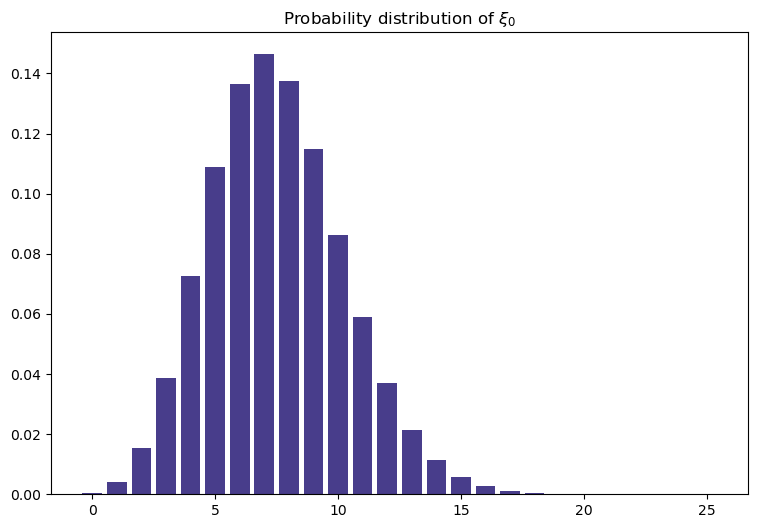

In [28]:
plt.figure(figsize = (9,6))

k = 0
plt.bar(np.arange(K+1), xi_distrib[k], color = 'darkslateblue')

plt.title(fr'Probability distribution of $\xi_{k}$')
plt.show()

Tthe distributions of the $k\xi_k$'s are almost the same as the $\xi_k$'s ones, the probabilities are the same but only not asigned to the same values (because $\mathbb{P}[k\xi_k = km] = \mathbb{P}[\xi_k = m]$.

In [36]:
kxi_distrib = np.zeros((N_max, (K+1)*N_max))
for k in range(N_max):
    lambdk = means[k]
    fact = 1
    for i in range(K+1):
        kxi_distrib[k, (k+1)*i] = np.exp(-lambdk) * lambdk ** i / fact
        fact *= (i+1)

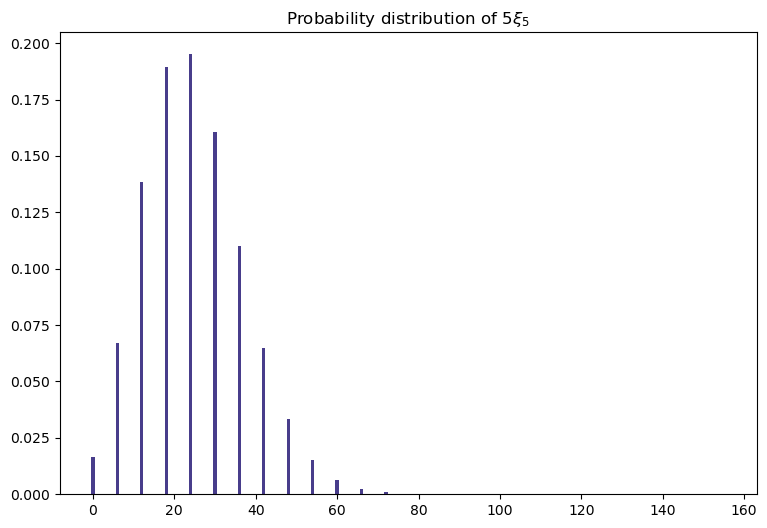

In [38]:
plt.figure(figsize = (9,6))

k = 5
plt.bar(np.arange((K+1)*N_max), kxi_distrib[k], color = 'darkslateblue')

plt.title(fr'Probability distribution of ${k}\xi_{k}$')
plt.show()

We finally know that for two r.v $X$ and $Y$, the distribution of $X+Y$ is given by the convolution of the distributions of $X$ and $Y$. Therefore we get that the distribution of $\displaystyle F(\phi) = \sum_{k=1}^{N_{\max}}{k\zeta_k}$ is given by :

In [45]:
F_distrib = np.convolve(kxi_distrib[0], kxi_distrib[1])
for k in range(1,N_max):
    F_distrib = np.convolve(F_distrib, kxi_distrib[k])

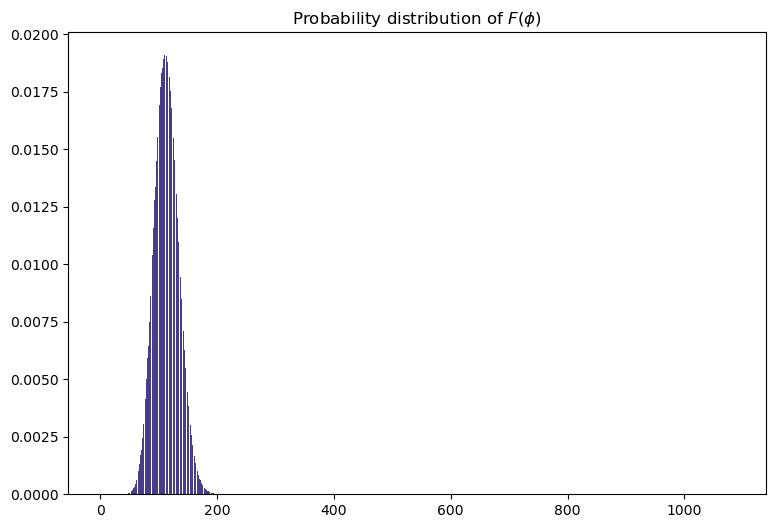

In [46]:
plt.figure(figsize = (9,6))

k = 5
plt.bar(np.arange(len(F_distrib)), F_distrib, color = 'darkslateblue')

plt.title(r'Probability distribution of $F(\phi)$')
plt.show()

### Question 10

We can finally compute the minimal $S$ to get a small enough probability of outage. For any $S$, the survival function of $F(\phi)$ is given by :

$\displaystyle \mathbb{P}[F(\phi) > S] = \sum_{m = S}^{KN_{max}}\mathbb{P}[F(\phi) = m]$

We get :

In [48]:
F_survival = 1 - F_distrib.cumsum()
S = 0
while F_survival[S] > 0.01:
    S += 1
print(S)

165


We can finally deduce that **the minimal number of slots** to have an outage probability smaller than $0.01$ **is** $\mathbf{165}$.